In [1]:
import scipy.io
import numpy as np

def load_emnist_byclass(path='emnist-byclass.mat'):
    mat = scipy.io.loadmat(path)
    data = mat['dataset']

    x_train = data['train'][0,0]['images'][0,0]
    y_train = data['train'][0,0]['labels'][0,0].flatten()

    x_test = data['test'][0,0]['images'][0,0]
    y_test = data['test'][0,0]['labels'][0,0].flatten()

    # Reshape images to 28x28 and transpose (order='F')
    x_train = x_train.reshape((-1, 28, 28), order='F').astype(np.uint8)
    x_test = x_test.reshape((-1, 28, 28), order='F').astype(np.uint8)

    # Get label mapping (index to ASCII)
    label_map = data['mapping'][0,0]

    # Find indices for letters only (A-Z or a-z)
    letter_indices = np.where(
        ((label_map[:, 1] >= 65) & (label_map[:, 1] <= 90)) |  # A-Z
        ((label_map[:, 1] >= 97) & (label_map[:, 1] <= 122))   # a-z
    )[0]

    allowed_labels = label_map[letter_indices, 0]

    # Create a remapping dict: old_label -> new_label (0..51)
    new_label_map = {old: i for i, old in enumerate(allowed_labels)}

    # Filter train set to letters only
    train_filter = np.isin(y_train, allowed_labels)
    x_train = x_train[train_filter]
    y_train = y_train[train_filter]
    y_train = np.vectorize(lambda l: new_label_map[l])(y_train)

    # Filter test set to letters only
    test_filter = np.isin(y_test, allowed_labels)
    x_test = x_test[test_filter]
    y_test = y_test[test_filter]
    y_test = np.vectorize(lambda l: new_label_map[l])(y_test)

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Add channel dimension for CNN: (N, 28, 28, 1)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

    return x_train, y_train, x_test, y_test

# Call function to load filtered EMNIST letters
x_train, y_train, x_test, y_test = load_emnist_byclass()
print(f"Train shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test shape: {x_test.shape}, Test labels shape: {y_test.shape}")


Train shape: (352897, 28, 28, 1), Train labels shape: (352897,)
Test shape: (58405, 28, 28, 1), Test labels shape: (58405,)


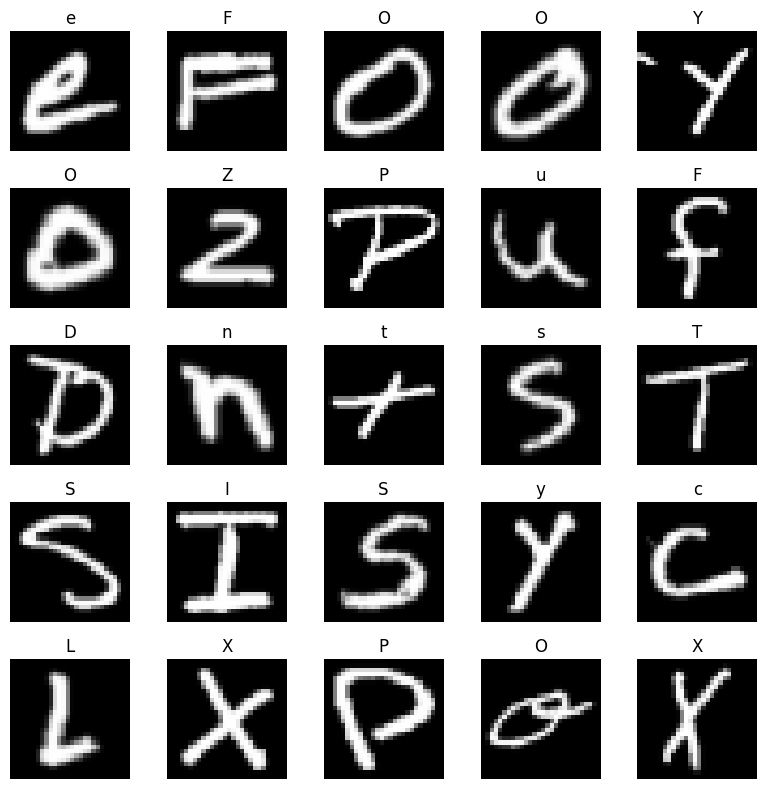

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Map numeric labels (0-51) to characters a-z and A-Z
def label_to_char(label):
    if label < 26:
        return chr(label + ord('A'))
    else:
        return chr(label - 26 + ord('a'))

def show_samples(images, labels, num_samples=25):
    plt.figure(figsize=(8, 8))
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(label_to_char(labels[idx]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
show_samples(x_train, y_train)


In [3]:
from tensorflow.keras import layers, models

def build_letter_classifier():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(52, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
model = build_letter_classifier()

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=64
)

Epoch 1/10
5515/5515 [==============================] - 61s 10ms/step - loss: 0.5675 - accuracy: 0.8115 - val_loss: 0.4058 - val_accuracy: 0.8481
Epoch 2/10
5515/5515 [==============================] - 56s 10ms/step - loss: 0.4334 - accuracy: 0.8453 - val_loss: 0.3753 - val_accuracy: 0.8592
Epoch 3/10
5515/5515 [==============================] - 55s 10ms/step - loss: 0.4037 - accuracy: 0.8533 - val_loss: 0.3578 - val_accuracy: 0.8668
Epoch 4/10
5515/5515 [==============================] - 55s 10ms/step - loss: 0.3870 - accuracy: 0.8579 - val_loss: 0.3538 - val_accuracy: 0.8672
Epoch 5/10
5515/5515 [==============================] - 56s 10ms/step - loss: 0.3741 - accuracy: 0.8614 - val_loss: 0.3509 - val_accuracy: 0.8671
Epoch 6/10
5515/5515 [==============================] - 56s 10ms/step - loss: 0.3632 - accuracy: 0.8649 - val_loss: 0.3429 - val_accuracy: 0.8723
Epoch 7/10
5515/5515 [==============================] - 57s 10ms/step - loss: 0.3563 - accuracy: 0.8667 - val_loss: 0.3487 -

In [4]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Predict on some test samples
import numpy as np

sample_indices = np.random.choice(len(x_test), 10, replace=False)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display predictions vs ground truth
for i, idx in enumerate(sample_indices):
    true_char = label_to_char(sample_labels[i])
    pred_char = label_to_char(predicted_labels[i])
    print(f"Sample {i+1}: True: {true_char} | Predicted: {pred_char}")


1826/1826 - 4s - loss: 0.3355 - accuracy: 0.8724 - 4s/epoch - 2ms/step
Test accuracy: 0.8724
1/1 [==============================] - 0s 133ms/step
Sample 1: True: O | Predicted: O
Sample 2: True: e | Predicted: e
Sample 3: True: t | Predicted: t
Sample 4: True: W | Predicted: w
Sample 5: True: r | Predicted: r
Sample 6: True: e | Predicted: e
Sample 7: True: m | Predicted: M
Sample 8: True: r | Predicted: r
Sample 9: True: P | Predicted: P
Sample 10: True: d | Predicted: d


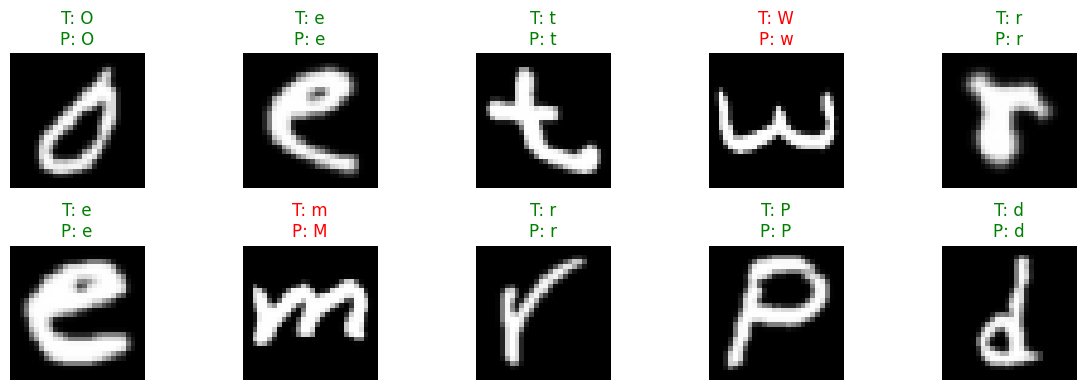

In [5]:
import matplotlib.pyplot as plt

def plot_predictions(images, true_labels, pred_labels):
    plt.figure(figsize=(12, 4))
    for i in range(len(images)):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        title_color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        plt.title(f"T: {label_to_char(true_labels[i])}\nP: {label_to_char(pred_labels[i])}",
                  color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(sample_images, sample_labels, predicted_labels)


In [6]:
# Save in HDF5 format (recommended for cross-notebook use)
model.save('emnist_letter_classifier.h5')